# Actor-Critic Single Agent Design

We build on the starter code developed by Chris Lamb (fellow student at UCSD), which is in turn built on PyTorch's Reinforcement Learning code for CartPole.

Chris' starter code has the following Actor-Critic Policy: [actor_critic_model.py](./actor_critic_model.py)

```python
# 4x3x80x80 input # Stack of 4 Atari game frames  

Policy(  
  (features): Sequential(  
    (0): Conv2d (4, 16, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))  
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)  
    (2): ReLU(inplace)  
    (3): Conv2d (16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))  
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)  
    (5): ReLU(inplace)  
  )  
  (action_head): Linear(in_features=256, out_features=6)  
  (value_head): Linear(in_features=256, out_features=1)  
)  

Action = softmax(action_head(x)/temperature)    
Value = value_head(x)
```  

We in turn evolve this into a Conv-LSTM network utilizing Truncated Backprop Thru Time (TBPTT).


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T

import os
import numpy as np
import timeit
import time
import platform
import random
import pickle as pickle
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())

Python version:  3.6.3


## Actor-Critic Model with LSTM (First Try)

Network Architecture:  [ac_lstm_model.py](./ac_lstm_model.py)

```python
# 4x3x80x80 input # Stack of 4 Atari game frame  

Policy(  
  (features): Sequential(  
    (0): Conv2d (4, 16, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))  
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)  
    (2): ReLU(inplace)  
    (3): Conv2d (16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))  
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)  
    (5): ReLU(inplace)  
    (6): Conv2d (32, 32, kernel_size=(4, 4), stride=(2, 2))  
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)  
    (8): ReLU(inplace)  
  )  
  (lstm): LSTMCell(512, 256)  
  (action_head): Linear(in_features=256, out_features=6)  
  (value_head): Linear(in_features=256, out_features=1)  
)  

Action = softmax(action_head(x)/temperature)    
Value = value_head(x)
```

Python code is located in [actor_critic_lstm.py](./actor_critic_lstm.py)

In [35]:
class Policy(torch.nn.Module):

    def __init__(self, input_channels, num_actions):
        super(Policy, self).__init__()
        self.temperature = 1.0
        self.input_channels = input_channels
        self.num_actions = num_actions
        self.features = self._init_features()
        self.lstm = self._init_lstm()
        self.action_head = self._init_action_head()
        self.value_head = self._init_value_head()
        
        self.saved_actions = []
        self.rewards = []

    def _init_features(self):
        layers = []
        # 80 x 80 x in_channels initial dimensions 3D array
        layers.append(torch.nn.Conv2d(self.input_channels,
                                      16, kernel_size=8, stride=4, padding=2))
        layers.append(torch.nn.BatchNorm2d(16))
        layers.append(torch.nn.ReLU(inplace=True))
        # 20 x 20 x 16 feature maps
        layers.append(torch.nn.Conv2d(16,
                                      32, kernel_size=4, stride=2, padding=1))
        layers.append(torch.nn.BatchNorm2d(32))
        layers.append(torch.nn.ReLU(inplace=True))
        # 10 x 10 x 32 feature maps
        layers.append(torch.nn.Conv2d(32,
                                      32, kernel_size=4, stride=2, padding=0))
        layers.append(torch.nn.BatchNorm2d(32))
        layers.append(torch.nn.ReLU(inplace=True))
        # 4 x 4 x 32 feature maps
        return torch.nn.Sequential(*layers)
    
    def _init_lstm(self):
        return torch.nn.LSTMCell(32*4*4, 256)

    def _init_action_head(self):
        return torch.nn.Linear(256, self.num_actions)

    def _init_value_head(self):
        return torch.nn.Linear(256, 1)

    def forward(self, inputs):
        x, (hx, cx) = inputs
        x = self.features(x)
        x = x.view(x.size(0), -1)  # 1 x 512(4x4x32)
        
        hx, cx = self.lstm(x, (hx, cx))
        x = hx
        
        action = torch.nn.functional.softmax(self.action_head(x) /
                                             self.temperature, dim=-1)
        value = self.value_head(x)
        return action, value, (hx, cx)


### Dimension Check

For building the architecture.

In [36]:
model = Policy(4,6)
print (model)
    
x = torch.randn(1,4,80,80)
cx = Variable(torch.zeros(1, 256))
hx = Variable(torch.zeros(1, 256))

action, value, (hx, cx) = model((Variable(x), (hx, cx)))        # Feed it through the model! 

print (ans.shape)
print (value.shape)
print (hx.shape)
print (cx.shape)


Policy(
  (features): Sequential(
    (0): Conv2d (4, 16, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU(inplace)
    (3): Conv2d (16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU(inplace)
    (6): Conv2d (32, 32, kernel_size=(4, 4), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU(inplace)
  )
  (lstm): LSTMCell(512, 256)
  (action_head): Linear(in_features=256, out_features=6)
  (value_head): Linear(in_features=256, out_features=1)
)
torch.Size([1, 512])
torch.Size([1, 1])
torch.Size([1, 256])
torch.Size([1, 256])


## Result

The Actor-Critic-LSTM achieves human performance in the game of Pong at approx 4000 episodes. The model created by Chris Lamb (without the LSTM) attains human performance at approx. 7000 episodes.

The model learns to running reward of 16.0 by the 9000 episodes. Its performance then crashed likely due to exploding gradient. This is because the current algorithm perform forward and backward prop through an entire game episode. We discover that in the game of Pong, there can be over 4000 game steps in a single episode.

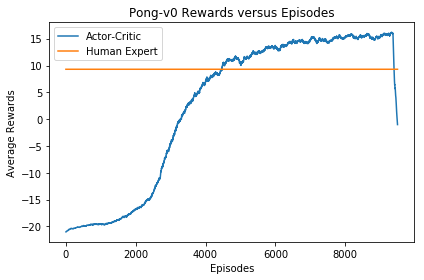

In [12]:
import matplotlib.pyplot as plt
import pickle
import argparse

human_scores = {'Asteroids-v0': 13157,
                'Breakout-v0': 31.8,
                'Pong-v0': 9.3,
                'SpaceInvaders-v0': 1652,
                }

game = 'Pong-v0'
data_file = './results/Pong-v0 (AC-lstm-fullepisode-ep=9500) (copy).p'.format(game)

with open(data_file, 'rb') as f:
    data = pickle.load(f)

human = [human_scores[game] for _ in range(len(data))]

plt.plot(data, label='Actor-Critic')
plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()
plt.show()

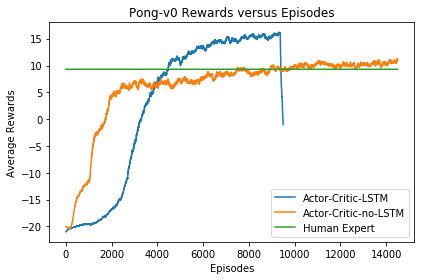

In [14]:
human_scores = {'Asteroids-v0': 13157,
                'Breakout-v0': 31.8,
                'Pong-v0': 9.3,
                'SpaceInvaders-v0': 1652,
                }

game = 'Pong-v0'
data_file = './results/Pong-v0 (AC-lstm-fullepisode-ep=9500) (copy).p'.format(game)

with open(data_file, 'rb') as f:
    data_lstm = pickle.load(f)

data_file = './results/Pong-v0-AC-noLSTM.p'.format(game)

with open(data_file, 'rb') as f:
    data_no_lstm = pickle.load(f)

human = [human_scores[game] for _ in range(len(data_no_lstm))]

plt.plot(data_lstm, label='Actor-Critic-LSTM')
plt.plot(data_no_lstm, label='Actor-Critic-no-LSTM')
plt.plot(human, label='Human Expert')
plt.title('{} Rewards versus Episodes'.format(game))
plt.xlabel('Episodes')
plt.ylabel('Average Rewards')
plt.legend()
plt.tight_layout()
plt.show()

## Actor-Critic-LSTM (Backprop thru Episode)

Network Architecture is the same:  [ac_lstm_model.py](./ac_lstm_model.py)

We implement a few improvements:
* [gradient clipping](http://pytorch.org/docs/master/_modules/torch/nn/utils/clip_grad.html)  
* Temperature annealing - We try to force the agent to explore (temp > 1.0) if running reward is less than 21.0, which the highest score possible for Pong.  

We still forward prop and backward prop through an entire game episode, which can exceed 4000 game steps. While LSTM can handle gradient vanishing well, it will not prevent gradient from exploding with such a long sequence. We noticed that the gradient norm (outputted by torch.nn.utils.clip_grad_norm) can be as high as 1000-5000, so we clip the gradient with max_norm=1000.

Python code is located in [actor_critic_lstm-episode.py](./actor_critic_lstm-episode.py)

## Actor-Critic-LSTM (Truncated Backprop through Time - TBPTT)

Network Architecture is the same:  [ac_lstm_model.py](./ac_lstm_model.py)

Truncated Backprop(TBP) 
* The general idea is based on Slide 41-44 of [CS231N_2017 Lecture 10](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture10.pdf) 
* Run forward and backward through chunks of sequence vs whole sequence. While hidden values hx and cx are carried forward in time forever.  

In this version, we forward prop and backward prop through multiple chunks (32 or 64 game steps) through a game episode. The gradient norm (outputted by torch.nn.utils.clip_grad_norm) is typically under 100, so we clip the gradient with max_norm=50.

Python code is located in [actor_critic_lstm-batch.py](./actor_critic_lstm-batch.py)